In [1]:
import pandas as pd
import seaborn as sns

# %%
df = pd.DataFrame(columns=["Cipher", "Mode", "CPU", "Length", "Speed"])


# %%
def addfile_2(cpu, filename, cipher, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for line in lines:
            if "---" in line:
                line = line.replace("-", '').replace("(Gbps)", "")
                mode = line.replace("speed test", "").strip()
                if "GCM" in mode:
                    mode = "AEAD"
            elif "length" in line:
                length, speed = line.split(',')[:2]
                length = int(length.split(":")[1])
                speed = float(speed.split(":")[1])
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

def addfile_3(cpu, filename, dftmp):
    with open(filename, "r", encoding="utf8", errors='ignore') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            if "type" in lines[i] and "bytes" in lines[i]:
                #type           8192 bytes
                length = int(lines[i].split()[1])
                speed = float(lines[i+1].split()[1][:-2]) / 1000 / 1000 * 8
                cipher = lines[i+1].split()[0]
                if "GCM" in cipher:
                    mode = "AEAD"
                else:
                    mode = "Encryption Only"
                dftmp = pd.concat([dftmp, pd.DataFrame([[cipher, mode, cpu, length, speed]], columns=dftmp.columns)], ignore_index=True)
    return dftmp

In [2]:
Devices = ["Apple M1", "Apple M2 Max", "Apple M3 Pro", "AMD EPYC 9334", "Intel Xeon Gold 6326", 
           "Intel Xeon Gold 6230", "Intel Xeon Silver 4108", "Intel Xeon E5-2620 v3", "AMD EPYC 7763",
            "AMD Ryzen 9 7950X", "Intel Core i9-13980HX"]
Devices = ["AMD EPYC 9334", "Intel Xeon Gold 6326", "Intel Xeon E5-2620 v3", "AMD Ryzen 9 7950X"]
Devices_dir = ["M1", "M2Max", "M3Pro", "EPYC9334", "IceLake", "Xeon6230", "Xeon4108", "E5-2620v3", "EPYC7763", "7950X", "13980HX"]
Devices_dir = ["EPYC9334", "IceLake", "E5-2620v3", "7950X"]
ciphers = ["HiAE", "ROCCA", "ROCCA-S", "AEGIS", "SNOW-V"]
ciphers_name = ["HiAE", "Rocca", "Rocca-S", "Aegis", "Snow-V"]
for device_id in range(len(Devices)):
    for id in range(5):
        if "Apple" not in Devices[device_id]:
            log_max = 11
        else:
            log_max = 4
        for i in range(1, log_max):
            df = addfile_2(Devices[device_id], f"{Devices_dir[device_id]}/{ciphers[id]}_log_{i}", ciphers_name[id], df)
    for cipher in ["AES-256-GCM", "AES-256-CTR"]:
        for i in range(1, 4):
            df = addfile_3(Devices[device_id], f"{Devices_dir[device_id]}/{cipher}_log_{i}", df)
df

,Cipher,Mode,CPU,Length,Speed
0,HiAE,Encryption Only,AMD EPYC 9334,16,8.710000
1,HiAE,Encryption Only,AMD EPYC 9334,64,17.300000
2,HiAE,Encryption Only,AMD EPYC 9334,256,104.530000
3,HiAE,Encryption Only,AMD EPYC 9334,512,150.380000
4,HiAE,Encryption Only,AMD EPYC 9334,1024,199.280000
...,...,...,...,...,...
3763,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,4096,94.087162
3764,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,2048,91.576658
3765,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,1024,87.280422
3766,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,256,64.839285


In [3]:
df = df[df["Length"] != 16]
df

,Cipher,Mode,CPU,Length,Speed
1,HiAE,Encryption Only,AMD EPYC 9334,64,17.300000
2,HiAE,Encryption Only,AMD EPYC 9334,256,104.530000
3,HiAE,Encryption Only,AMD EPYC 9334,512,150.380000
4,HiAE,Encryption Only,AMD EPYC 9334,1024,199.280000
5,HiAE,Encryption Only,AMD EPYC 9334,2048,236.400000
...,...,...,...,...,...
3763,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,4096,94.087162
3764,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,2048,91.576658
3765,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,1024,87.280422
3766,AES-256-CTR,Encryption Only,AMD Ryzen 9 7950X,256,64.839285


In [4]:
df.to_csv("logs.csv", index=False)
#对每一类去掉最大最小值进行平均
for CPU in df["CPU"].unique():
    for cipher in df["Cipher"].unique():
        for mode in df["Mode"].unique():
            for length in df["Length"].unique():
                df_tmp = df[(df["CPU"] == CPU) & (df["Cipher"] == cipher) & (df["Mode"] == mode) & (df["Length"] == length)]
                df = df.drop(df_tmp[df_tmp["Speed"] == df_tmp["Speed"].min()].index)
df
df_avg = df.groupby(['Cipher', 'Mode', 'CPU', 'Length']).mean().reset_index()
df_avg.to_csv("logs_avg.csv", index=False)
df_avg

,Cipher,Mode,CPU,Length,Speed
0,AES-256-CTR,Encryption Only,AMD EPYC 9334,64,22.566953
1,AES-256-CTR,Encryption Only,AMD EPYC 9334,256,46.367973
2,AES-256-CTR,Encryption Only,AMD EPYC 9334,1024,62.002749
3,AES-256-CTR,Encryption Only,AMD EPYC 9334,2048,66.044654
4,AES-256-CTR,Encryption Only,AMD EPYC 9334,4096,68.235576
...,...,...,...,...,...
363,Snow-V,Encryption Only,Intel Xeon Gold 6326,1024,30.875556
364,Snow-V,Encryption Only,Intel Xeon Gold 6326,2048,37.153333
365,Snow-V,Encryption Only,Intel Xeon Gold 6326,4096,40.401111
366,Snow-V,Encryption Only,Intel Xeon Gold 6326,8192,42.853333


C:\Users\Concyclics\AppData\Local\Temp\ipykernel_49204\3835692733.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(data=df_avg[(df_avg['CPU'] == CPU_name) & (df_avg['Mode'] == Mode_name)& (df_avg['Length'] < 17000) & (df_avg['Length'] >=64)], x='Length', y='Speed', hue="Cipher", palette="tab10")


Text(0.5, 1.0, 'Benchmark on Intel Core i9-13980HX')

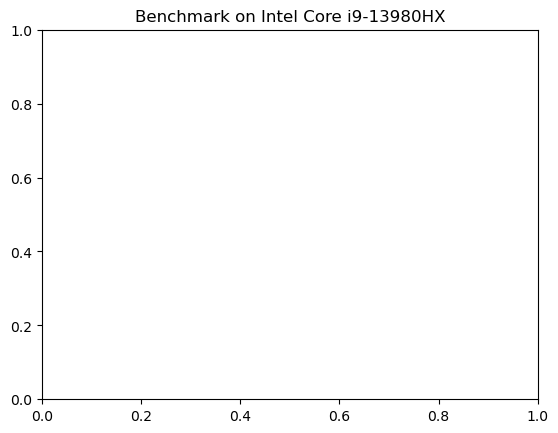

In [5]:
CPU_name = "Intel Core i9-13980HX"
Mode_name = 'AEAD'
import matplotlib.pyplot as plt
sns.lineplot(data=df_avg[(df_avg['CPU'] == CPU_name) & (df_avg['Mode'] == Mode_name)& (df_avg['Length'] < 17000) & (df_avg['Length'] >=64)], x='Length', y='Speed', hue="Cipher", palette="tab10")
plt.title("Benchmark on " + CPU_name)

In [7]:
#Devices = ["Apple M1", "Apple M2 Max", "Apple M3 Pro", "AMD EPYC 9334", "Intel Xeon Gold 6326", 
#          "Intel Xeon Gold 6230", "Intel Xeon Silver 4108", "Intel Xeon E5-2620 v3", "AMD EPYC 7763",
#            "AMD Ryzen 9 7950X", "Intel Core i9-13980HX"]
ciphers_name = ["HiAE", "Rocca", "Rocca-S", "Aegis", "Snow-V", "AES-256"]
for device in Devices:
    print("\\multicolumn{16}{|c|}{\\textbf{" + device + "}}\\\\\n\\hline")
    for cipher in ciphers_name:
        s = ""
        for mode in ["Encryption Only", "AEAD"]:
            if cipher == "Snow-V":
                if mode == "AEAD":
                    s += f"& SNOW-V-GCM "
                else:
                    s += f"& SNOW-V "
            elif cipher == "Aegis":
                s += f"& AEGIS-128L "
            elif cipher == "HiAE":
                s += f"& HiAE (this work) "
            elif "AES-256" in cipher:
                if mode == "AEAD":
                    cipher = "AES-256-GCM"
                else:
                    cipher = "AES-256-CTR"
                s += f"& {cipher} "
            else:
                s += f"& {cipher} "
        
            for lens in [16384, 8192, 4096, 2048, 1024, 256, 64]:
                speed_value = df_avg.loc[(df_avg["Cipher"] == cipher) & (df_avg["Mode"] == mode) & (df_avg["Length"] == lens) & (df_avg["CPU"] == device), "Speed"].values
                if len(speed_value) > 0:
                    if speed_value[0] == max(df_avg.loc[(df_avg["Mode"] == mode) & (df_avg["Length"] == lens) & (df_avg["CPU"] == device), "Speed"].values):
                        s += " & \\textbf{" f"{speed_value[0]:.2f}" + "} "
                        #s += f" & {speed_value[0]:.2f} "
                    else:
                        s += f" & {speed_value[0]:.2f} "
                else:
                    s += " & N/A "
        print(s[1:] + "\\\\")
    print("\\hline")

\multicolumn{16}{|c|}{\textbf{AMD EPYC 9334}}\\
\hline
 HiAE (this work)  & \textbf{262.91}  & \textbf{261.00}  & \textbf{248.15}  & \textbf{236.49}  & \textbf{198.89}  & \textbf{104.40}  & 17.29 & HiAE (this work)  & \textbf{252.17}  & \textbf{230.21}  & \textbf{201.12}  & \textbf{166.41}  & \textbf{116.50}  & 44.38  & 8.98 \\
 Rocca  & 192.25  & 186.87  & 173.97  & 121.00  & 90.12  & 41.37  & 14.58 & Rocca  & 185.83  & 172.65  & 150.91  & 120.32  & 85.79  & 31.27  & 8.88 \\
 Rocca-S  & 162.45  & 155.47  & 145.68  & 128.72  & 83.14  & 38.15  & 13.60 & Rocca-S  & 156.90  & 145.69  & 127.90  & 103.41  & 73.96  & 27.84  & 8.04 \\
 AEGIS-128L  & 139.60  & 138.16  & 134.31  & 124.06  & 112.39  & 53.88  & 20.95 & AEGIS-128L  & 138.94  & 135.28  & 127.85  & 115.51  & 96.57  & \textbf{48.61}  & \textbf{16.01} \\
 SNOW-V  & 33.67  & 32.70  & 30.88  & 27.82  & 23.20  & 11.55  & 2.80 & SNOW-V-GCM  & 14.67  & N/A  & N/A  & 14.26  & 13.82  & 11.66  & 7.17 \\
 AES-256-CTR  & 70.35  & 69.96  & 68.24